# Install required packages 

In [3]:
# install required packages for the project

%pip install torch torchvision torchaudio -quit --index-url https://download.pytorch.org/whl/cpu
%pip install -quit matplotlib
%pip install -quit safetensors


Usage:   
  /home/ram/Desktop/DeepLearning/env/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /home/ram/Desktop/DeepLearning/env/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /home/ram/Desktop/DeepLearning/env/bin/python -m pip install [options] [-e] <vcs project url> ...
  /home/ram/Desktop/DeepLearning/env/bin/python -m pip install [options] [-e] <local project path> ...
  /home/ram/Desktop/DeepLearning/env/bin/python -m pip install [options] <archive url/path> ...

no such option: -u
Note: you may need to restart the kernel to use updated packages.

Usage:   
  /home/ram/Desktop/DeepLearning/env/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /home/ram/Desktop/DeepLearning/env/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /home/ram/Desktop/DeepLearning/env/bin/python -m pip install [options] [-e] <vcs project url>

##   import necessary libraries

In [4]:
# import necessary libraries
import time
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

## Load dataset

In [5]:
train_dataset = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
)

In [6]:
test_dataset = datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
)

In [7]:
print(len(train_dataset), len(test_dataset))

60000 10000


## Converting data in to batches

In [8]:
batch_size = 64

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

print(len(train_loader), len(test_loader))

938 157


In [9]:
 # Train the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)
# Evaluate the model
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return total_loss / len(test_loader), accuracy


In [10]:

class LogisticRegression(nn.Module):
    def __init__(self,in_dim,n_class):
        super().__init__()
        self.in_dim = in_dim
        self.n_class = n_class
        self.linear = nn.Linear(in_dim, n_class)

    def forward(self, x):
        out=self.linear(x)
        return out



In [11]:
model = LogisticRegression(28*28,10)
print(model)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [12]:
model.state_dict()
print(model.state_dict().keys())
print(model.state_dict()['linear.weight'].shape)
print(model.state_dict()['linear.bias'].shape)
# Set device

odict_keys(['linear.weight', 'linear.bias'])
torch.Size([10, 784])
torch.Size([10])


In [13]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.0214,  0.0049,  0.0297,  ...,  0.0075,  0.0281, -0.0100],
        [ 0.0162, -0.0328, -0.0171,  ..., -0.0237,  0.0334,  0.0348],
        [-0.0283, -0.0050,  0.0241,  ..., -0.0137, -0.0225,  0.0129],
        ...,
        [-0.0087, -0.0295,  0.0104,  ..., -0.0213,  0.0223,  0.0041],
        [ 0.0108,  0.0318, -0.0196,  ...,  0.0088,  0.0020,  0.0152],
        [ 0.0354,  0.0178,  0.0205,  ..., -0.0296, -0.0231,  0.0353]],
       requires_grad=True), Parameter containing:
tensor([-0.0116,  0.0311, -0.0334, -0.0127, -0.0058,  0.0154, -0.0297,  0.0171,
         0.0330,  0.0333], requires_grad=True)]


In [14]:
# For CuDA support, check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cpu


In [15]:
# for MPS support (Apple Silicon Macs)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print(device)

cpu


In [16]:
# Loss function and optimizer
learning_rate = 1e-2
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)


# Building Training loop

In [17]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    print("*"*20)
    start_time = time.time()
    running_loss=0
    running_acc=0
    model.train()
    for i ,data in enumerate(train_loader,1):
        images, labels = data
        # Flatten the images
        images = images.view(images.size(0), -1)  # Flatten the images
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        # running_acc += (predicted == labels).sum().item()
        running_acc += (predicted == labels).float().mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {running_acc / i:.4f}")
    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {end_time - start_time:.2f} seconds, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {running_acc / len(train_loader):.4f}")


********************
Epoch [1/5], Step [100/938], Loss: 0.2694, Accuracy: 0.7739
Epoch [1/5], Step [200/938], Loss: 0.4029, Accuracy: 0.8227
Epoch [1/5], Step [300/938], Loss: 0.5392, Accuracy: 0.8433
Epoch [1/5], Step [400/938], Loss: 0.2799, Accuracy: 0.8550
Epoch [1/5], Step [500/938], Loss: 0.2438, Accuracy: 0.8629
Epoch [1/5], Step [600/938], Loss: 0.4277, Accuracy: 0.8684
Epoch [1/5], Step [700/938], Loss: 0.3795, Accuracy: 0.8728
Epoch [1/5], Step [800/938], Loss: 0.2202, Accuracy: 0.8763
Epoch [1/5], Step [900/938], Loss: 0.2066, Accuracy: 0.8791
Epoch [1/5] completed in 19.07 seconds, Loss: 0.4003, Accuracy: 0.8799
********************
Epoch [2/5], Step [100/938], Loss: 0.2379, Accuracy: 0.9059
Epoch [2/5], Step [200/938], Loss: 0.3208, Accuracy: 0.9073
Epoch [2/5], Step [300/938], Loss: 0.2042, Accuracy: 0.9045
Epoch [2/5], Step [400/938], Loss: 0.2811, Accuracy: 0.9048
Epoch [2/5], Step [500/938], Loss: 0.3660, Accuracy: 0.9048
Epoch [2/5], Step [600/938], Loss: 0.3481, Accu

In [18]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    print("*" * 20)
    start_time = time.time()
    running_loss = 0
    total_correct = 0
    total_samples = 0

    model.train()
    for i, data in enumerate(train_loader, 1):
        images, labels = data
        images = images.view(images.size(0), -1)  # Flatten the images
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        # print(outputs, labels.data,outputs.shape)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        # print(total_correct, total_samples)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            accuracy = total_correct / total_samples
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], "f"Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    end_time = time.time()
    # print(f"Outputs : {outputs}")
    # print(f"Outputs Data : {outputs.data}")
    print(total_correct, total_samples)
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = total_correct / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {end_time - start_time:.2f} seconds, "f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


********************
Epoch [1/5], Step [100/938], Loss: 0.2130, Accuracy: 0.9120
Epoch [1/5], Step [200/938], Loss: 0.0995, Accuracy: 0.9145
Epoch [1/5], Step [300/938], Loss: 0.2021, Accuracy: 0.9166
Epoch [1/5], Step [400/938], Loss: 0.3490, Accuracy: 0.9173
Epoch [1/5], Step [500/938], Loss: 0.3042, Accuracy: 0.9183
Epoch [1/5], Step [600/938], Loss: 0.3458, Accuracy: 0.9187
Epoch [1/5], Step [700/938], Loss: 0.2701, Accuracy: 0.9183
Epoch [1/5], Step [800/938], Loss: 0.3535, Accuracy: 0.9185
Epoch [1/5], Step [900/938], Loss: 0.1898, Accuracy: 0.9178
55072 60000
Epoch [1/5] completed in 22.44 seconds, Loss: 0.2949, Accuracy: 0.9179
********************
Epoch [2/5], Step [100/938], Loss: 0.2532, Accuracy: 0.9144
Epoch [2/5], Step [200/938], Loss: 0.4482, Accuracy: 0.9191
Epoch [2/5], Step [300/938], Loss: 0.2041, Accuracy: 0.9190
Epoch [2/5], Step [400/938], Loss: 0.3768, Accuracy: 0.9184
Epoch [2/5], Step [500/938], Loss: 0.2083, Accuracy: 0.9189
Epoch [2/5], Step [600/938], Loss: 

In [19]:
# # Test the model
# model.eval()
# eval_loss=0
# eval_acc=0
# with torch.no_grad():
#     predicted=model(x_train)

# # Make predictions
# print(predicted)

In [20]:
model.eval()  #for checking how good is your model on the test dataset  (for evaluation )
eval_loss = 0.
eval_acc = 0.
start_time = time.time()
for data in test_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    img=img.to(device)
    label=label.to(device)
    with torch.no_grad(): # because here we do not need gradients because we are just testing our model,
        out = model(img)
        loss = criterion(out, label)
    eval_loss += loss.item()
    _, pred = torch.max(out, 1) #getting prediction from our model for testing the result
    eval_acc += (pred == label).float().mean()
print(f'Test Loss: {eval_loss/len(test_loader):.6f}, Acc: {eval_acc/len(test_loader):.6f}')
print(f'Time:{(time.time()-start_time):.1f} s')

Test Loss: 0.284059, Acc: 0.920482
Time:2.5 s


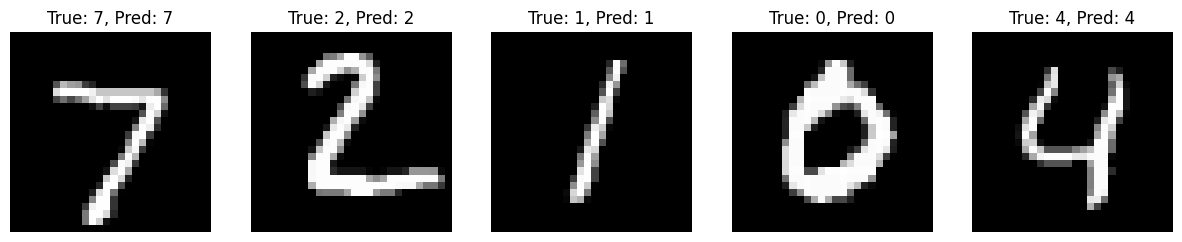

In [21]:
# Visualizing some predictions
images, labels = next(iter(test_loader))
images = images.reshape(-1, 28*28).to(device)
labels = labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
#fig is a reference to the entire figure.
#ax is an array of Axes objects, and each Axes object can be used to draw a plot. Since there are 5 subplots, ax contains 5 such objects.
#figsize=(15, 3) sets the size of the entire figure to 15 inches wide and 3 inches tall.
fig, ax = plt.subplots(1, 5, figsize=(15, 3)) #The arguments (1, 5) specify that the figure should have 1 row of 5 columns, i.e., 5 subplots aligned horizontally.
for i in range(5):
    ax[i].imshow(images[i].reshape(28, 28).cpu(), cmap='gray')
    ax[i].set_title(f'True: {labels[i].item()}, Pred: {predicted[i].item()}')
    ax[i].axis('off')
plt.show()

In [24]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.1115, -0.2757, -0.0721],
                        [-0.2917,  0.1002,  0.0712],
                        [ 0.4092, -0.2178,  0.1892]]],
              
              
                      [[[-0.2099, -0.2176,  0.0430],
                        [-0.3396,  0.0480,  0.1452],
                        [-0.1777,  0.2699,  0.3321]]],
              
              
                      [[[ 0.1618, -0.1161, -0.0458],
                        [-0.0068, -0.0842, -0.1038],
                        [-0.0530,  0.1861,  0.3739]]],
              
              
                      [[[ 0.2809,  0.4026,  0.0467],
                        [ 0.3103,  0.0407,  0.3026],
                        [-0.1526, -0.1617, -0.1505]]],
              
              
                      [[[ 0.4393, -0.3035, -0.1950],
                        [ 0.1597, -0.1124, -0.2020],
                        [ 0.2683,  0.1814, -0.2309]]],
              
              
               

In [25]:
torch.save(model.state_dict(),'./LogisticRegression.pth')

In [22]:
# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [23]:
# Initialize the model, criterion, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


KeyboardInterrupt: 

In [ ]:
# Save the model
torch.save(model.state_dict(), 'mnist_cnn.pth')
# Load the model
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('mnist_cnn.pth', map_location=device))
# Evaluate the loaded model
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f'Loaded Model - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


In [ ]:
# Visualize some predictions
def visualize_predictions(model, test_loader, device):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        ax = axes[i]
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        ax.set_title(f'Pred: {predicted[i].item()}\nTrue: {labels[i].item()}')
        ax.axis('off')
    plt.show()
visualize_predictions(model, test_loader, device)


In [ ]:
# Save the model in safetensors format
import safetensors.torch
safetensors.save_model(model, 'mnist_cnn.safetensors')
# Load the model from safetensors format
model = safetensors.load_model(SimpleCNN(), 'mnist_cnn.safetensors', map_location=device)
# Evaluate the loaded model from safetensors
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f'Loaded Safetensors Model - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
# Clean up      
import os  
os.remove('mnist_cnn.pth')
os.remove('mnist_cnn.safetensors')
print("Cleaned up model files.")
# End of the script
if __name__ == "__main__":
    print("Script executed successfully.")
    sys.exit(0)
# End of the script
# End of the script 